# [IAPR 2020:][iapr2020] Lab 1 ‒  Image segmentation

**Author:** Arild Madshaven
**Due date:** 26.03.2020

[iapr2018]: https://github.com/LTS5/iapr-2020

## Extract relevant data
We first need to extract the `lab-01-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [3]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-01-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

## Part 1: Brain segmentation

Your goal: compute the size of the brain (in pixels) in a 2D image of a human head taken by Magnetic Resonance Imaging (MRI).
* Try as many methods as you can, the more the better.
* At least region growing and contour detection.

### 1.1 Brain image visualization

In [5]:
import skimage.io
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Load image
data_path = os.path.join(data_base_path, data_folder)
brain_im = skimage.io.imread(os.path.join(data_path, 'brain-slice40.tiff'))

#### Visualization fns

In [5]:
def plotHist(im, dsc='', bins=256):
    'Plot image histogram'
    
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    ax.hist(im.ravel(), bins=bins)
    ax.set_title(dsc)
    plt.show()

In [6]:
def plotImages(images, cmaps=None, dsc=None):
    'Visualize images side-by-side'
    
    n = len(images)
    if cmaps == None: cmaps = ['gray']*n
    if dsc == None: dsc = ['']*n
        
    fig, ax = plt.subplots(1, n, figsize=(6*n, 10))
    

    for i, im in enumerate(images):
        if n == 1:
            ax.imshow(im, cmap=cmaps[i], vmin=0, vmax=255)
            ax.set_title(dsc[i])
            ax.axis('off')
        else:
            ax[i].imshow(im, cmap=cmaps[i], vmin=0, vmax=255)
            ax[i].set_title(dsc[i])
            ax[i].axis('off')

    plt.show()

In [7]:
def plotImageAndHistogram(im, dsc='Image'):
    'Visualize image and its histogram side-by-side'
    
    fig, ax = plt.subplots(1,2,figsize=(20,5))
    ax[0].imshow(im, cmap='gray')
    ax[0].axis('off')
    ax[0].set_title(dsc)
    ax[1].hist(im.ravel(), 256)
    ax[1].set_title(dsc + ' histogram')
    plt.show()

## 1.2 Region growing

**First approach**: Try to detach brain tissue from skull by thresholding.

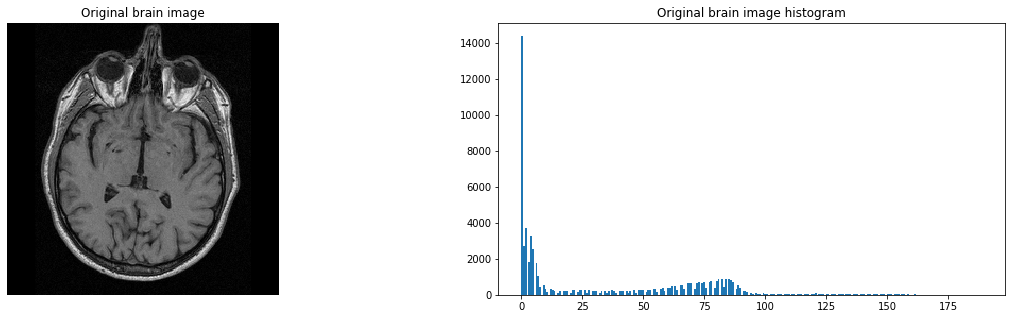

In [8]:
plotImageAndHistogram(brain_im, 'Original brain image')

**Thoughts**: 
   * The brain is light grey and partly surrounded by a dark ring. In the top it is connected to light matter. It should be possible to separate the brain from the surroundings by thresholding. This could make the region growing work easier. 
   * From the histogram we observe that most pixels are dark and few are bright, though there is a peak between 75 and 100. This is probably where the brightest area of the skull is. Our brain tissue is probably somewhere in between.
   * A lower threshold of 45 and upper threshold of 91 yielded a good result in our estimation. These boundaries were approached by extensive testing.

In [9]:
def thresholder(im, l_thr, u_thr, invert=False):
    'Return image where pixel values outside threshold boundaries are maximized or minimized'
    
    trf = im.copy()
    if not invert:
        trf[trf < l_thr] = 0
        trf[u_thr < trf] = 255
    else:
        trf[trf < l_thr] = 255
        trf[u_thr < trf] = 0       
    return trf

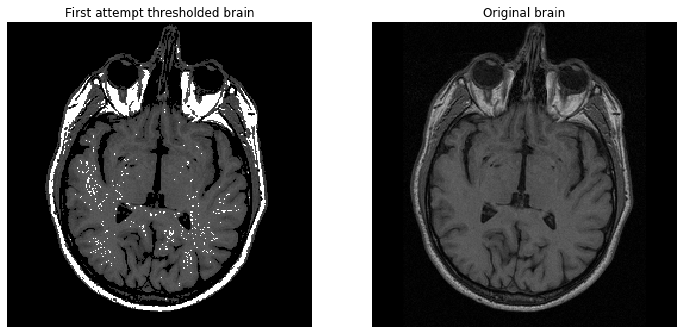

In [11]:
l_thr, u_thr = (45, 91)
t_brain = thresholder(brain_im, l_thr, u_thr)
plotImages([t_brain, brain_im], dsc=['First attempt thresholded brain', 'Original brain'])

**Thoughts**
* We initially set brighter areas to white and applied median filters to handle the 'salt' noise in the brain tissue.
* From here we would detect brain tissue as 'the large thing that is connex and neither white nor black'.
* *However* a more interesting result was achieved by setting bright pixels dark:

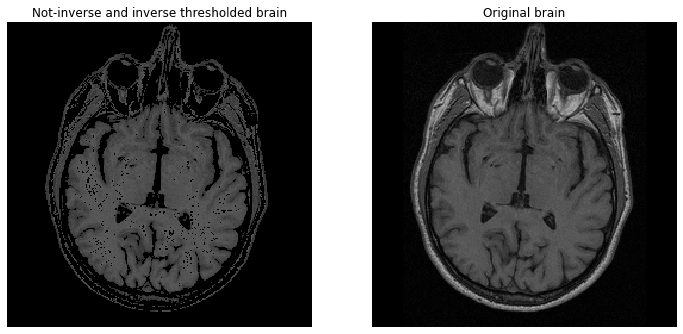

In [12]:
l_thr, u_thr = (45, 255)
t_brain = thresholder(brain_im, l_thr, u_thr)
l_thr, u_thr = (0, 91)
t_brain = thresholder(t_brain, l_thr, u_thr, invert=True)
plotImages([t_brain, brain_im], dsc=['Not-inverse and inverse thresholded brain', 'Original brain'])

**Thoughts**
* A trade-off has to be made between sparsity of connections between brain and skull, and loss of brain pixels.
* The lower the upper threshold, the more 'pepper' inside the brain, and the sparser the connections.
* We ended up implementing a gaussian filter at the start of the process to even out the brain tissue pixel values.

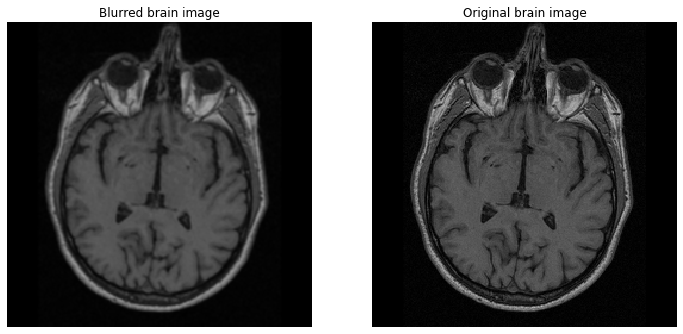

In [13]:
b_brain = cv2.GaussianBlur(brain_im, (3,3), 1)
plotImages([b_brain, brain_im], dsc=['Blurred brain image', 'Original brain image'])

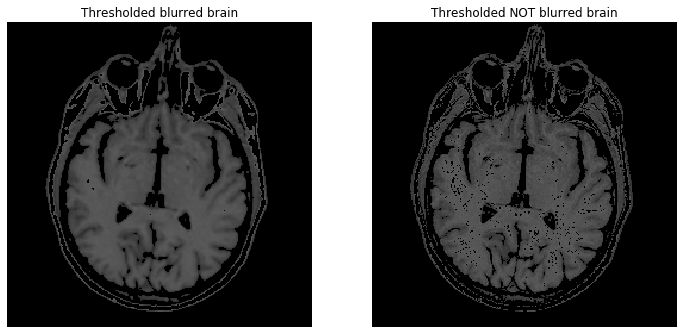

In [14]:
l_thr, u_thr = (45, 255)
tb_brain = thresholder(b_brain, l_thr, u_thr)
l_thr, u_thr = (0, 91)
tb_brain = thresholder(tb_brain, l_thr, u_thr, invert=True)
plotImages([tb_brain, t_brain], dsc=['Thresholded blurred brain', 'Thresholded NOT blurred brain'])

**Continuing to work on the blurred, thresholded image**

The weak connections can be broken by opening. Structuring element was chosen to minimize colatteral damage to the image. I.e. as small as possible.

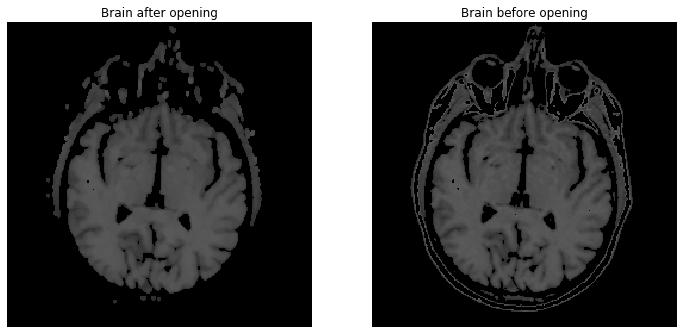

In [16]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,4))
o_brain = cv2.morphologyEx(tb_brain, cv2.MORPH_OPEN, kernel)
plotImages([o_brain, tb_brain], dsc=['Brain after opening', 'Brain before opening'])

**Thoughts**
* The brain is the largest 'not-black thing'.
* Initially we found the region by identifying *one* pixel coordinate that is part of the brain and use it as a single seed.
* We expanded on the algorithm to make a grid of seeds across the image.
* For the time being, it is sufficient that every seed identifies its neighbours which are *not black*.


In [17]:
def createIndexGrid(image_shape, distance):
    'Creates an evenly spaced grid of cooridates across an image'
    
    indices = set()
    
    for xi in range(image_shape[0]):
        for yi in range(image_shape[1]):
            if not xi%distance and not yi%distance: indices.add((xi, yi))            
    return indices

In [18]:
def markIndices(im, indices):
    'Returns a copy of the image where indices are white'
    
    tp = im.copy()
    for i in indices: tp[i] = 255
    
    return tp

**Ensure** at least one seed is within brain tissue.

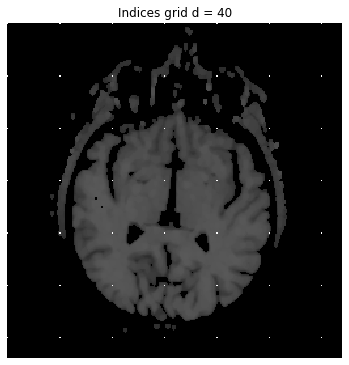

In [19]:
seed_d = 40

seeds = createIndexGrid(o_brain.shape, seed_d)
ind_im = markIndices(o_brain, seeds)
plotImages([ind_im], dsc=[f'Indices grid d = {seed_d}'])

In [20]:
def neighbourInRange(lower, upper, neighbour, _):
    'Helper fn for region growing'
    
    return lower < neighbour < upper

In [21]:
def collectRegion(seed, visited, im, lower_threshold, upper_threshold, fn=neighbourInRange, HIGHEST_PIX_VALUE=255):
    'Returns a region of pixel coordinate neighbours which satisfy the region criterion set by _fn_'

    detected = set([seed])
    region = set()

    x_min = y_min = 0
    x_max, y_max = im.shape
    
    while len(detected):
        
        pix = detected.pop()
        
        if pix in visited: continue
                
        pix_val = im[pix]
        
        x, y = pix
    
        for xi in range(max(x-1, x_min), min(x+2, x_max), 2):
            if ((xi, y)) in visited: continue
            if fn(lower_threshold, upper_threshold, im[xi, y], pix_val): detected.add((xi, y))
        for yi in range(max(y-1, y_min), min(y+2, y_max), 2):
            if ((x, yi)) in visited: continue
            if fn(lower_threshold, upper_threshold, im[x, yi], pix_val): detected.add((x, yi))
                
        region.add(pix)
        visited.add(pix)
        
    return list(region)

In [22]:
def collectAllRegions(seeds, im, min_region_size, l_thr, u_thr, fn=neighbourInRange):
    'Runs collectRegion for every seed and returns a list of all connex regions in the image'
    
    regions = []
    visited = set()

    for seed in seeds:
        
        if seed in visited: continue
            
        region = collectRegion(seed, visited, im, l_thr, u_thr, fn=fn)
        
        if len(region)>=min_region_size: regions.append(region)
        else: visited -= set(region)
        
    return regions, visited

In [23]:
l_thr, u_thr = (1, 255)
min_region_size = 1000

'For the time being - we are looking for pixels that are NOT all black, and an area of - say - at least 1000 connex pixels'

regions, visited_pixels = collectAllRegions(seeds, o_brain, min_region_size, l_thr, u_thr)

In [24]:
len(regions)

2

So **two** regions satisfy these criterions. Let's try to visualize them on the original brain:

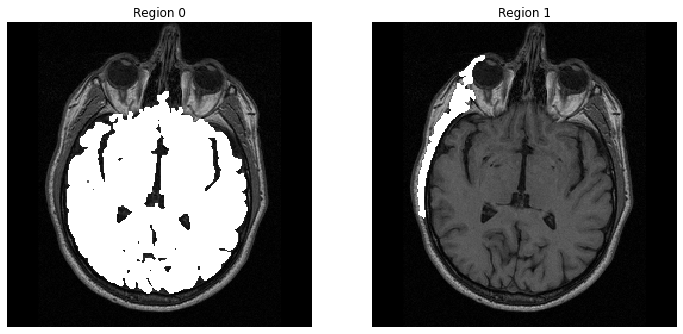

In [25]:
ind_brains = [markIndices(brain_im, r) for r in regions]
plotImages(ind_brains, dsc=[f'Region {i}' for i in range(len(regions))])

**Clearly** we're looking for region 0. The size of which is the measured size of the brain.

In [26]:
result_threshold_opening = ind_brains[0]
size_threshold_opening = len(regions[0])
print(f'Estimated brain size: {size_threshold_opening}')

Estimated brain size: 17502


**Thoughts**
* The measurement is crude, probably due to sub-optimal thresholding, blurring and opening.
* What if we used a *relative* criterion instead of an absolute threshold? That is - neighbours that *look* alike are part of the same region.

In [27]:
def neighbourInRelativeRange(lower, upper, neighbour, current):
    'Helper fn for region growing'
    
    return current-lower < neighbour < current+upper

Trying first to grow regions based on the original image and the seed grid from before:

In [28]:
l_thr, u_thr = (8, 8)
min_region_size = 1000

regions, visited_pixels = collectAllRegions(seeds, brain_im, min_region_size, l_thr, u_thr, fn=neighbourInRelativeRange)

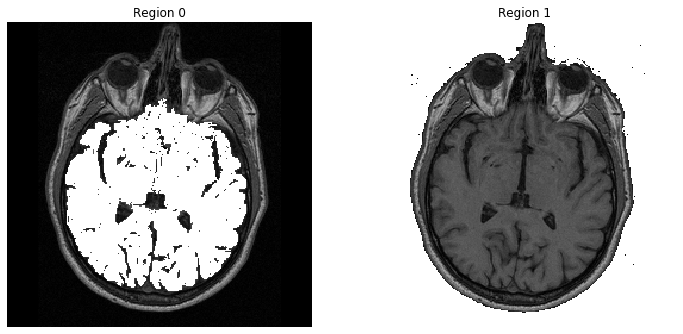

In [29]:
ind_brains = [markIndices(brain_im, r) for r in regions]
plotImages(ind_brains, dsc=[f'Region {i}' for i in range(len(regions))])

Still yields some noise and boundary issues, so we'll apply gaussian filter and thresholding like before the previous opening  

In [30]:
l_thr, u_thr = (5, 5)
min_region_size = 1000

'tb_brain is the thresholded and blurred brain from before opening'

regions, visited_pixels = collectAllRegions(seeds, tb_brain, min_region_size, l_thr, u_thr, fn=neighbourInRelativeRange)

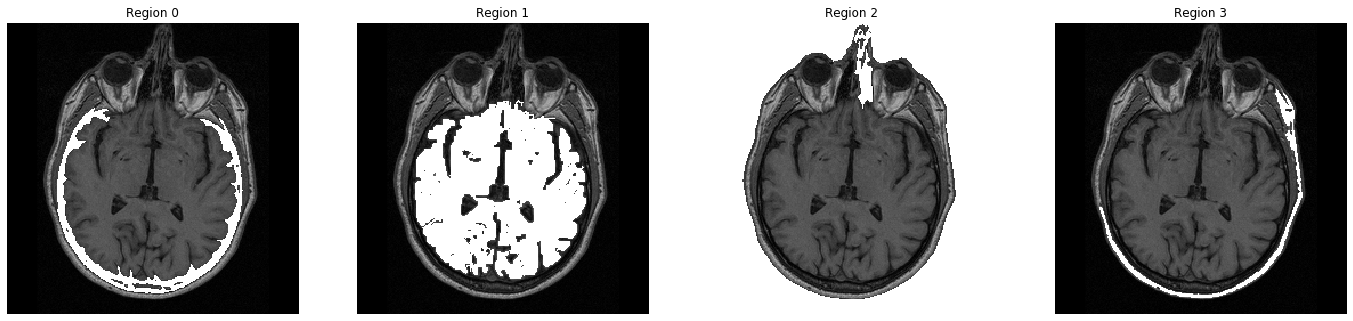

In [31]:
ind_brains = [markIndices(brain_im, r) for r in regions]
plotImages(ind_brains, dsc=[f'Region {i}' for i in range(len(regions))])

**Region 1** is our brain. We'll see how it looks compared to our old best result:

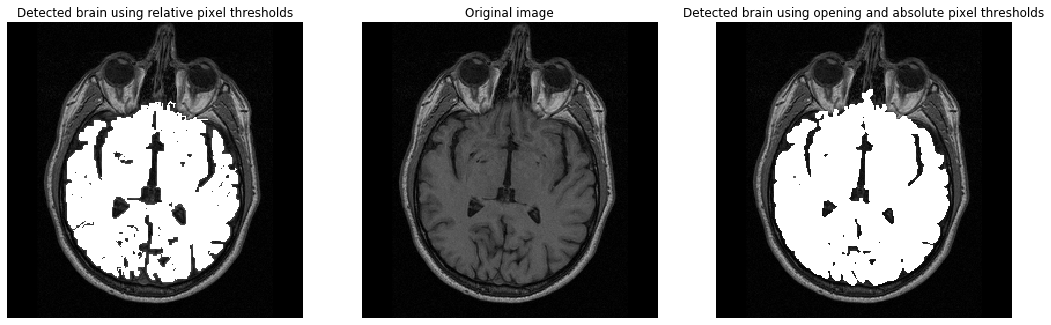

In [34]:
result_relative_neighbours = ind_brains[1]
size_relative_neighbours = len(regions[1])
plotImages([result_relative_neighbours, brain_im, result_threshold_opening], 
           dsc=['Detected brain using relative pixel thresholds', 'Original image', 'Detected brain using opening and absolute pixel thresholds'])

In [35]:
print(f"Estimated size of brain: {size_relative_neighbours}")

Estimated size of brain: 15344


### 1.2.1 Discussion

"Brain using opening and absolute pixel thresholds" (Image 1) gave a 2158 larger brain size compared to "using relative pixel thresholds"(Image 2). Comparing the marked areas of brain image 1 and 2 to the original image, more contours and smaller black areas are more present at image 2. Image 2 looks to have the most valid representation of the brain. The loss of the smaller black areas of image 1 could be due to, overapplying opening and thereby closing the black sections.

## 1.3 Contour detection

**First approach:** Constructing a Marr-Hildreth kernel

In [36]:
def LoG(sigma, x, y):
    'Laplacian of Gaussian equation'
    return -1/(np.pi * sigma**4)*np.exp(-(x**2+y**2)/(2*sigma**2))*(1 - (x**2+y**2)/(2*sigma**2))

In [37]:
from sklearn.preprocessing import normalize

def constructLoGKernel(sigma, size=7):
    'Returns kernel approximation of the LoG equation'
    'Larger simga implies more noise reduction'
    'Larger size implies better filter approximation'
    
    assert size%2, 'Kernel must be odd'
    
    kernel = np.zeros((size,size))
    mid = size//2
    
    for y in range(-mid, mid+1):
        for x in range(-mid, mid+1):
            kernel[x+mid, y+mid] = LoG(sigma,x,y)
            
    kernel = normalize(kernel, axis=1, norm='l1')
    return kernel

In [38]:
def printKernel(k, dsc='',round_val=2):
    
    print(dsc)
    for row in k:
        for e in row: print(round(e, 2), end='\t')
        print()

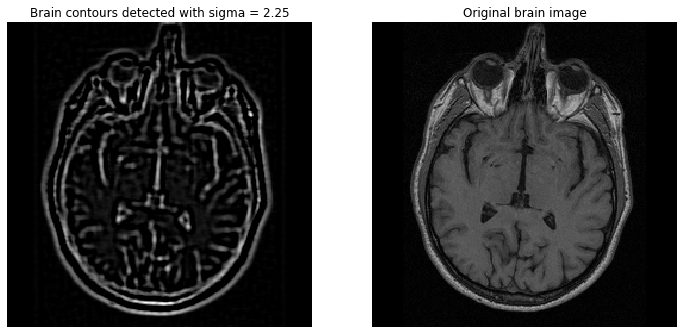

Marr-Hildreth kernel
0.09	0.12	0.13	0.12	0.11	0.12	0.13	0.12	0.09	
0.17	0.18	0.11	-0.01	-0.06	-0.01	0.11	0.18	0.17	
0.08	0.05	-0.06	-0.19	-0.25	-0.19	-0.06	0.05	0.08	
0.04	-0.0	-0.1	-0.22	-0.27	-0.22	-0.1	-0.0	0.04	
0.03	-0.01	-0.11	-0.22	-0.26	-0.22	-0.11	-0.01	0.03	
0.04	-0.0	-0.1	-0.22	-0.27	-0.22	-0.1	-0.0	0.04	
0.08	0.05	-0.06	-0.19	-0.25	-0.19	-0.06	0.05	0.08	
0.17	0.18	0.11	-0.01	-0.06	-0.01	0.11	0.18	0.17	
0.09	0.12	0.13	0.12	0.11	0.12	0.13	0.12	0.09	


In [39]:
sigma = 2.25 
kernel_size = 9
LoG_kernel = constructLoGKernel(sigma, kernel_size)

brain_LoG = cv2.filter2D(brain_im, -1, LoG_kernel) 
plotImages([brain_LoG, brain_im], dsc=[f'Brain contours detected with sigma = {sigma}', 'Original brain image'])
printKernel(LoG_kernel, 'Marr-Hildreth kernel')

**Thoughts**
* We settled for a kernel size of 9. Different sizes were tried, but 9 seemed to be more than sufficient to approximate the filter.
* The ideal value range for sigma is very narrow. We tried to select sigma s.t. a more or less connext brain region could be achieved.
* Would results be better if we could stretch the histogram a bit?

In [40]:
def normalizeHist(im, new_max):
    'Return image where pixel values are stretched from 0 to new_max'
    
    c = im.copy().astype('float64')
    min_val = c.min()
    max_val = c.max()
        
    c -= min_val
    c /= (max_val - min_val)
    
    return (c * new_max).astype('uint8')

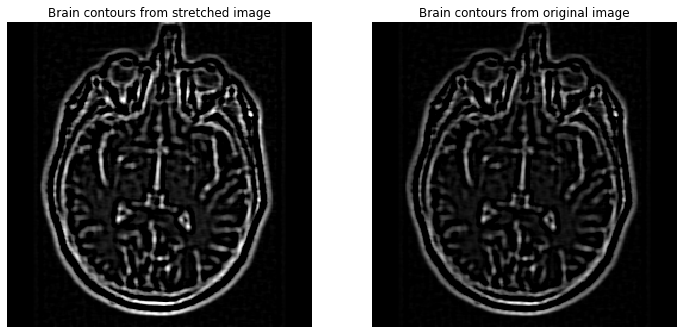

In [41]:
n_brain = normalizeHist(brain_im, 255)
n_brain_LoG = cv2.filter2D(n_brain, -1, LoG_kernel) 
plotImages([n_brain_LoG, brain_LoG], dsc=[f'Brain contours from stretched image', 'Brain contours from original image'])

Edges are definitely stronger after image is stretched. This might give us room to increase sigma a bit.

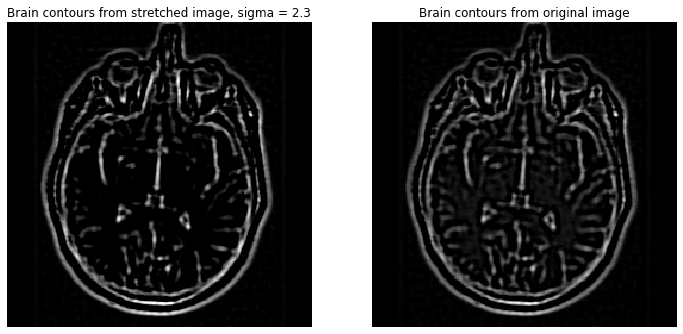

In [42]:
sigma = 2.3 
LoG_kernel = constructLoGKernel(sigma, kernel_size)
n_brain_LoG = cv2.filter2D(n_brain, -1, LoG_kernel) 
plotImages([n_brain_LoG, brain_LoG], dsc=[f'Brain contours from stretched image, sigma = {sigma}', 'Brain contours from original image'])

**Applying closing** to achieve enclosed brain region

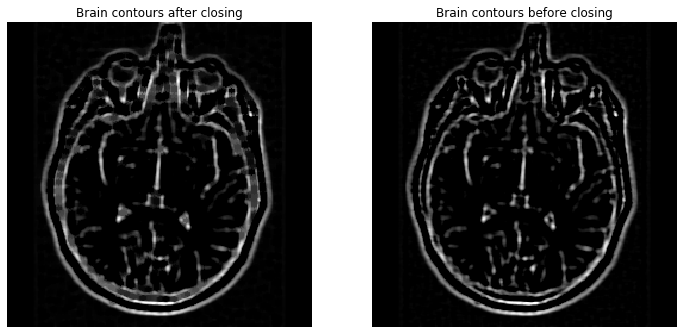

In [43]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
c_brain_LoG = cv2.morphologyEx(n_brain_LoG, cv2.MORPH_CLOSE, kernel)
plotImages([c_brain_LoG, n_brain_LoG], dsc=['Brain contours after closing', 'Brain contours before closing'])

**Again**, applying seeds. Now looking for larger black regions.

In [44]:
seed_d = 40
seeds = createIndexGrid(c_brain_LoG.shape, seed_d)

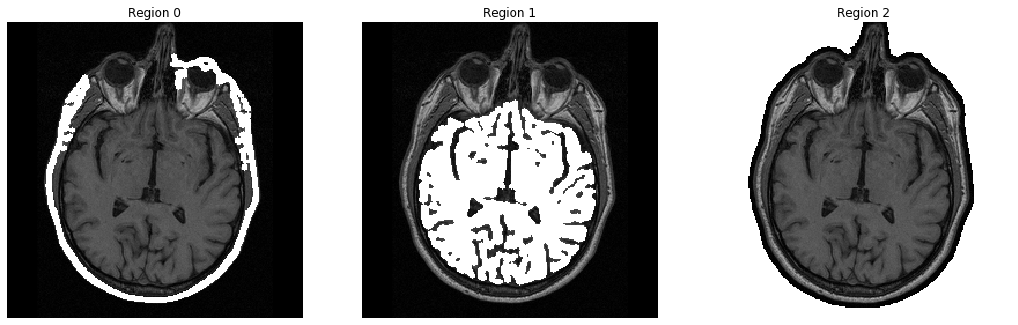

In [45]:
l_thr, u_thr = (-1, 20)
min_region_size = 1000

regions, visited_pixels = collectAllRegions(seeds, c_brain_LoG, min_region_size, l_thr, u_thr)

ind_brains = [markIndices(brain_im, r) for r in regions]
plotImages(ind_brains, dsc=[f'Region {i}' for i in range(len(regions))])

Region 1 looks quite good. Fetching our newest brain size estimate:

In [46]:
result_LoG = ind_brains[1]
size_LoG = len(regions[1])
print(f'Size of brain: {size_LoG}')

Size of brain: 15444


### I have tried to incoorperate this in the discussion - Mathies
#### Remember for discussion: 
[https://en.wikipedia.org/wiki/Edge_detection] The early Marr–Hildreth operator is based on the detection of zero-crossings of the Laplacian operator applied to a Gaussian-smoothed image. It can be shown, however, that this operator will also return false edges corresponding to local minima of the gradient magnitude. Moreover, this operator will give poor localization at curved edges. Hence, this operator is today mainly of historical interest.

## 1.3 Additional method(s)

### Canny edge detection

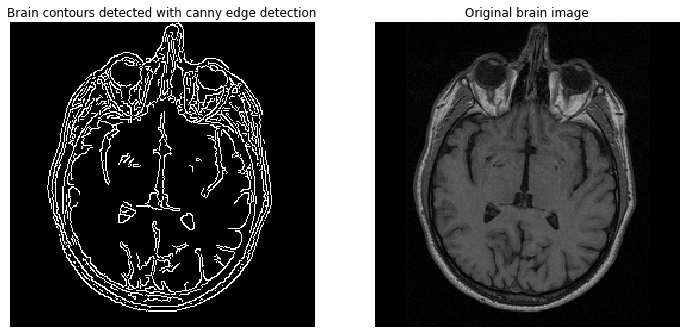

In [54]:
'Set upper threshold to be three times lower threshold and fine-tune lower threshold'

l_thr = 70
u_thr = 3*l_thr
canny_brain = (cv2.Canny(brain_im, l_thr, u_thr))
plotImages([canny_brain, brain_im], dsc=['Brain contours detected with canny edge detection', 'Original brain image'])

**Applying** fine-grained closing to ensure enclosed brain

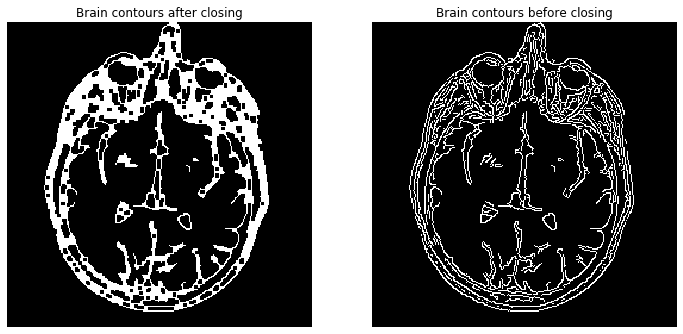

In [55]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(3,3))
ccanny_brain = cv2.morphologyEx(canny_brain, cv2.MORPH_CLOSE, kernel)
plotImages([ccanny_brain, canny_brain], dsc=['Brain contours after closing', 'Brain contours before closing'])

In [56]:
seed_d = 40
seeds = createIndexGrid(ccanny_brain.shape, seed_d)

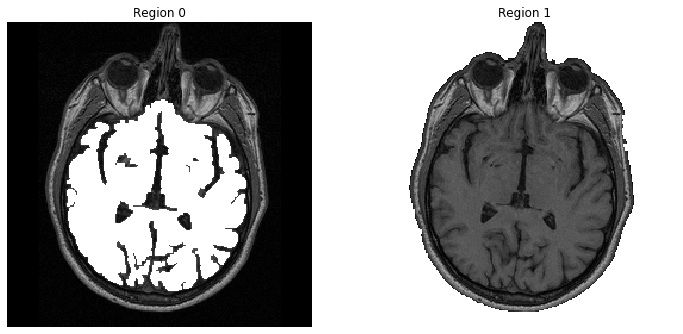

In [57]:
l_thr, u_thr = (-1, 20)
min_region_size = 1000

regions, visited_pixels = collectAllRegions(seeds, ccanny_brain, min_region_size, l_thr, u_thr)

ind_brains = [markIndices(brain_im, r) for r in regions]
plotImages(ind_brains, dsc=[f'Region {i}' for i in range(len(regions))])

In [60]:
result_canny = ind_brains[0]
size_canny = len(regions[0])
print(f'Estimated brain size: {size_canny}')

Estimated brain size: 15536


### Discussion

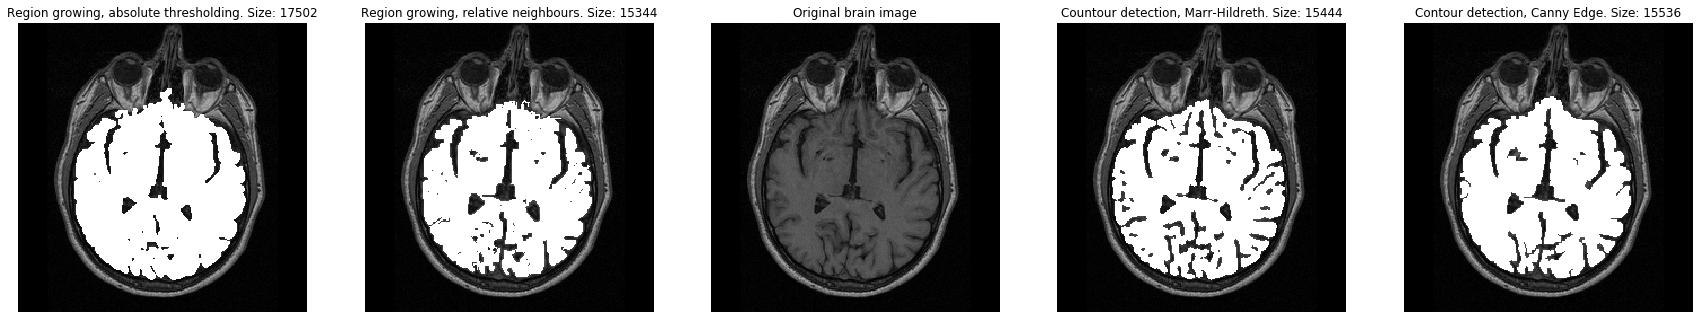

In [61]:
plotImages([result_threshold_opening, result_relative_neighbours, brain_im, result_LoG, result_canny],
          dsc=[f'Region growing, absolute thresholding. Size: {size_threshold_opening}',
               f'Region growing, relative neighbours. Size: {size_relative_neighbours}',
               'Original brain image',
               f'Contour detection, Marr-Hildreth. Size: {size_LoG}',
               f'Contour detection, Canny Edge. Size: {size_canny}'])

**Thougts:**
* Three images are in the same brain size range: 15344 - 15444. 
* The first image is notable bigger in size, as previous mentioned this is most likely due to the loss of small contours cause by to much opening / preprocessing.
* The Marr-Hildret method worked well, after some image restoration. The success of this method is probably due to the simple nature of the picture, which results in a small noise contribution.
* Furthermore, it should be noted that a successful brain size estimation was obtained using region growing and region growing on contour detection.

## Part 2: Shape/color segmentation

You will find hereafter three pictures taken under three different illuminations, containing some shapes with different colors. We ask you to create a routine to:

1. Count the number of shapes of each color.
2. Compute the total area (in pixels) of each color.

Please note that one specific challenge is to be robust to illumination changes. Therefore some kind of intensity normalization should probably be used.

**Note:** the routine(s) that you will write for this exercise will be useful for the final project as well, so pay special attention to it.

### 2.1 Visualization

In [10]:
# Load images
im_names = ['arena-shapes-01', 'arena-shapes-02', 'arena-shapes-03']
filenames = [os.path.join(data_path, name) + '.png' for name in im_names]
ic = skimage.io.imread_collection(filenames)
images = skimage.io.concatenate_images(ic)
NUM_IMAGES = images.shape[0]
NUM_COLORS = images.shape[-1]
print('Number of images: ', images.shape[0])
print('Image size: {}, {} '.format(images.shape[1], images.shape[2]))
print('Number of color channels: ', images.shape[-1])

Number of images:  3
Image size: 480, 640 
Number of color channels:  3


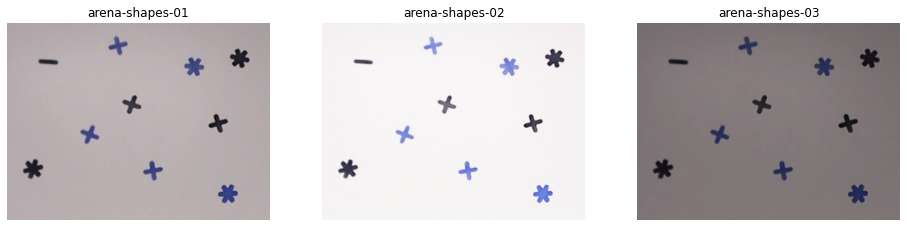

In [11]:
# Plot images
def plot_imgs(images, cmap = None, im_names = ['arena-shapes-01', 'arena-shapes-02', 'arena-shapes-03']):
    fig, axes = plt.subplots(1, NUM_IMAGES, figsize=(16, 16))
    for ax, im, nm in zip(axes.ravel(), images, im_names):
        ax.imshow(im, cmap = cmap)
        ax.axis('off')
        ax.set_title(nm)
    plt.show()

plot_imgs(images)

### Preprocessing

In this section we wish to preprocess the images such that it is possible to segment the colors regardless of image intensity. Following techniques is applied:  

- RBG to Greyscale
- Normalizing
- Standardizing
- Histogram equalization
- Intensity rescaling


### MÅSKE BEHOLD

In the ended up with intensity rescaling which reduces the number of distinct values in the image.  
How we tested each method follows here.

#### RGB to Greyscale

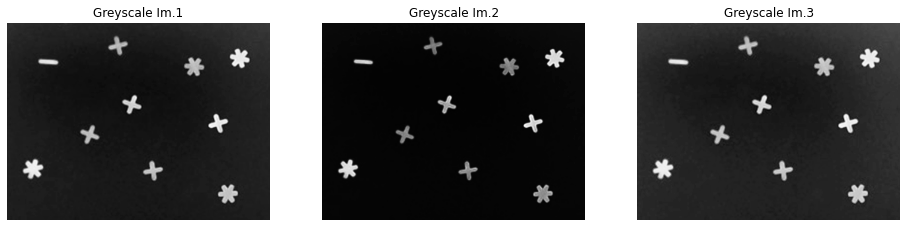

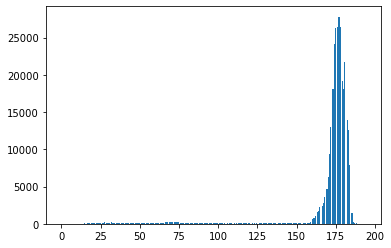

In [12]:
from skimage.color import rgb2grey
greys = [(rgb2grey(images[i])*255).astype(int) for i in range(NUM_IMAGES)]

plot_imgs(greys, cmap = 'Greys', im_names = ['Greyscale Im.1', 'Greyscale Im.2', 'Greyscale Im.3'])

plt.hist(greys[0].ravel(), bins = 256)
plt.show()


**Thoughts:**

Working with greyscale is in many ways easier than RGB. However, this cannot be used here as we can see in the histogram above.  
We only get one peak, which makes it unable to distingush the different colors.

#### Normalizing images

Mean pixel value before: 174.48659288194443
Mean pixel value after: 216.29489691840277

Mean pixel value before: 241.1303949652778
Mean pixel value after: 244.39402886284722

Mean pixel value before: 118.77575629340278
Mean pixel value after: 202.63930989583332



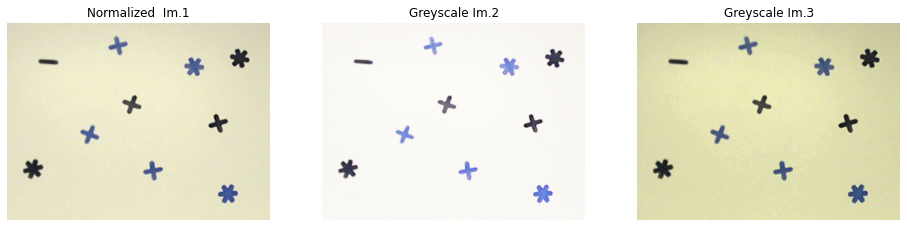

In [13]:
def normalize_img(img):
    print('Mean pixel value before:', np.mean(img) )
    img_min = img.min(axis = (0, 1))
    img_max = img.max(axis = (0, 1))
    norm_img = (((img - img_min)/(img_max-img_min))*255).astype(int)
    print('Mean pixel value after:', np.mean(norm_img))
    print()
    return norm_img
    
    
norm_imgs = [normalize_img(images[i]) for i in range(NUM_IMAGES)]
plot_imgs(norm_imgs,  im_names = ['Normalized  Im.1', 'Greyscale Im.2', 'Greyscale Im.3'])

**Thoughts:**

Normalizing is done by taking advantage of the whole spectrum of 0-255 values, in each channel (RGB). As seen in the above pictures the result does not differ much from the original image. This technique is therefore disregarded.

#### Standardizing

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


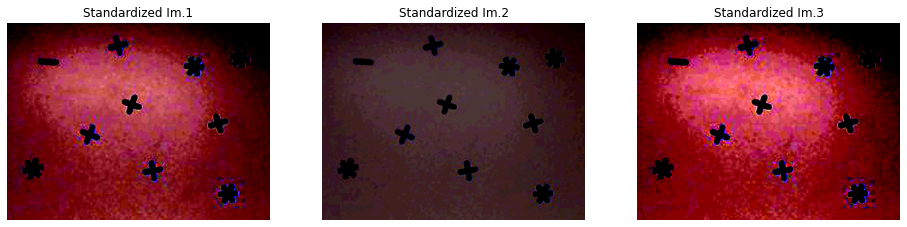

In [21]:
# Standardizing removes to much color information

def standardize_img(img):
    
    img_mean = img.mean()
    img_std = img.std()
    std_img = ((img-img_mean)/img_std)

    return std_img

std_imgs = [standardize_img(images[i]) for i in range(NUM_IMAGES)]
plot_imgs(std_imgs, im_names = ['Standardized Im.1', 'Standardized Im.2', 'Standardized Im.3'])


**Thoughts:**

Standardizing produces zero-mean and standard deviation of 1. This resulted in too much loss of color information. Therefore this technique is disregarded.

#### Histogram equalization

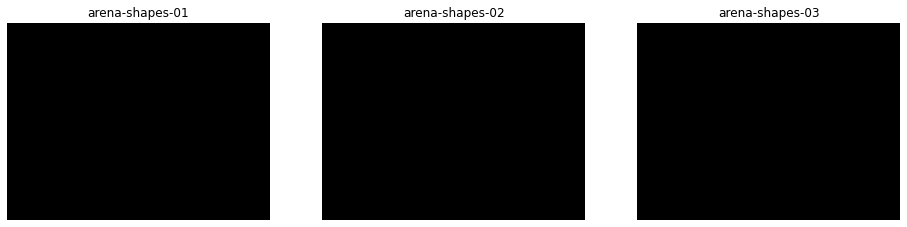

In [22]:
from skimage.exposure import equalize_hist

def histogram_equalization(org_img):
    img = org_img.copy()
    for i in range(img.shape[2]):
        img[:, :, i] = equalize_hist(img[:, :, i])
        
    return img

hist_imgs = [histogram_equalization(images[i]) for i in range(NUM_IMAGES)]
plot_imgs(hist_imgs)


### What do we write here - Mathies
**Thoughts:** 

Too be honest I am not sure about what happend when using histogram equalization.
All values ended up as 0, which does not really make sense.

#### Rescale Intensity

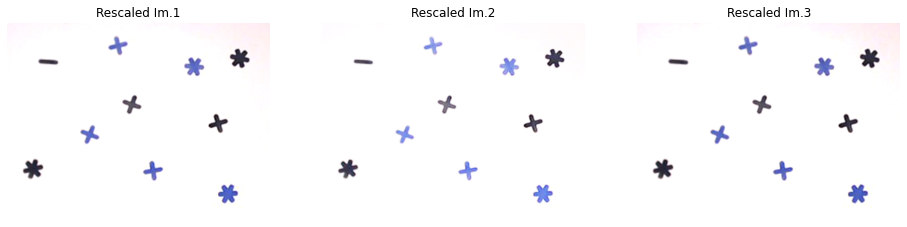

In [23]:
from skimage.exposure import rescale_intensity


def equalize_intensity(img):
    """
    """
    p2, p98 = np.percentile(img, (0, 10))
    return rescale_intensity(img, in_range=(p2,p98))


eq_imgs = [equalize_intensity(images[i]) for i in range(NUM_IMAGES)]

plot_imgs(eq_imgs, im_names = ['Rescaled Im.1', 'Rescaled Im.2', 'Rescaled Im.3'])

**Thoughts:**

As seen in the above pictures, Rescale Intensity produces by far the best result. The method uses the darker (lower) values of the image, while setting all grey parts to white. 

### 2.2 Number of shapes of each color
Add your implementation and discussion

Histogram of equalized image nr. 1


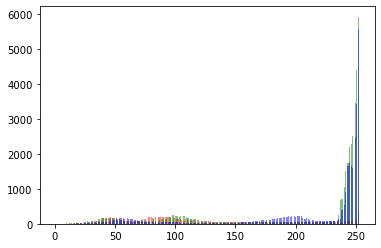

Histogram of equalized image nr. 2


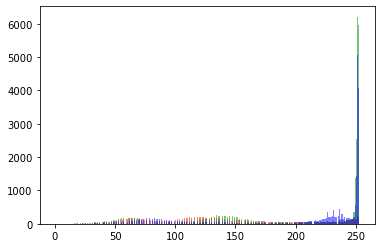

Histogram of equalized image nr. 3


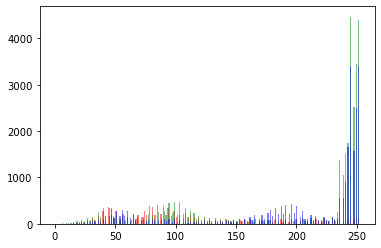

In [38]:
def remove_white(img, ch):
    '''
    Help function so that histogram is not dominated by white pixels
    '''
    img_ch = img[:,:, ch].ravel()
    return img_ch[img_ch != 255]
    
def plot_rgb_hist(img):
    ''' 
    Plots histogram of each channel/color on top of eachother.
    '''
    plt.hist(remove_white(img, 0), bins = 255, color = 'red', alpha = 0.5)
    plt.hist(remove_white(img, 1), bins = 255, color = 'green', alpha = 0.5)
    plt.hist(remove_white(img, 2), bins = 255, color = 'blue', alpha = 0.5)
    
    plt.show()

for i in range(3):
    print('Histogram of equalized image nr.', i + 1)
    plot_rgb_hist(eq_imgs[i])
    
plt.show()

**Thoughts:**

The images shows distinctive peaks of different gaussian distributions, which should be able to provide us with threshold values. Furthermore, the peak at 250 corresponds to the many white pixel observations.

## Segmentation
In this section we wish to do thresholding and labeling of the regions

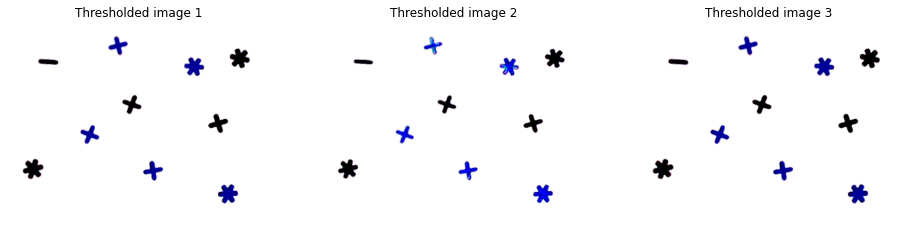

In [39]:
def thresholding(img):
    '''
    Has a lower and upper threshold which is used to segment the two colors
    Values have been found from looking at histogram.
    '''
    lt = 160

    ut = 230
    
    thres_img = img.copy()
    
    thres_img[thres_img < lt] = 0
    thres_img[(thres_img >= lt) & (thres_img < ut) ] = 150
    thres_img[thres_img >= ut] = 255
    
    return thres_img
    

imgs_thres = [thresholding(eq_imgs[i]) for i in range(NUM_IMAGES)]
plot_imgs(imgs_thres, im_names = ['Thresholded image 1', 'Thresholded image 2', 'Thresholded image 3'])

### Region Growing

In [40]:
def is_white(pixel):
    '''
    Check if all RBG values are white
    '''
    return  np.all(np.isin(pixel, 255))

def collect_region(start, im_arr):
    '''
    Moves out from start and ads pixel to region if it is not white.
    Is running as long as there are are connected non-white pixels.
    '''

    detected = set([start])
    visited = set()

    x_min = y_min = 0
    x_max, y_max = im_arr.shape[0:2]
    
    while len(detected):
        
        pix = detected.pop()
        if pix in visited: continue

        x, y = pix
        for xi in range(max(x-2, x_min), min(x+2, x_max), 1):
            if not is_white(im_arr[xi, y]): detected.add((xi, y))
        for yi in range(max(y-2, y_min), min(y+2, y_max), 1):
             if not is_white(im_arr[x, yi]): detected.add((x, yi))
        
        visited.add(pix)  
    
    return visited


In [46]:
import time
def region_growing(img):
    
    '''
    Goes through all pixels and adds region.
    Has a minimum region-size in case of left out pixels.
    
    '''
    
    min_region_size = 50
    regions = []
    visited_pixels = set()
    
    tic = time.time()
    count = 0
    for row in range(img.shape[0]):
        for col in range(img.shape[1]):
            
            if is_white(img[row, col]) or (row, col) in visited_pixels: continue
            count -=- 1
            region = collect_region((row, col), img)
            
            if len(region) > min_region_size: regions.append(region)
            visited_pixels |= region
            
    toc = time.time()

    print('Found {} regions in {} seconds.'.format(len(regions), np.around(toc-tic)))
    return regions


Executing function: median



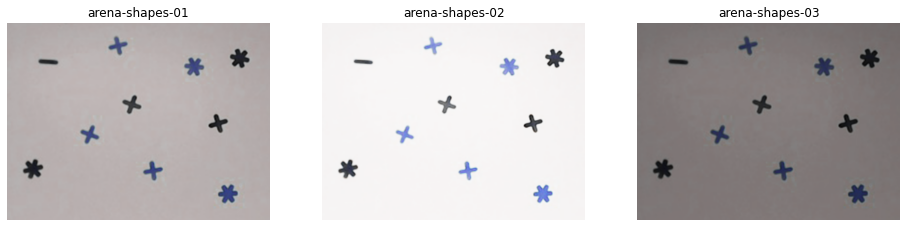

Executing function: equalize_intensity



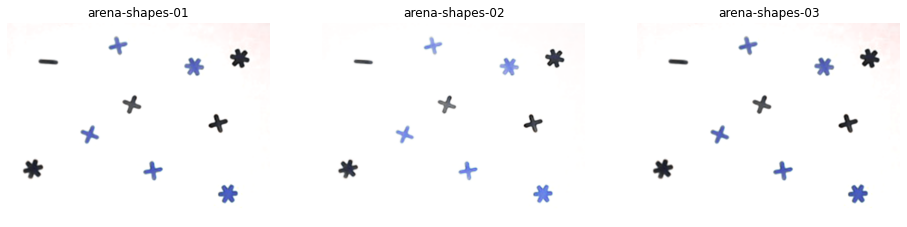

Executing function: thresholding



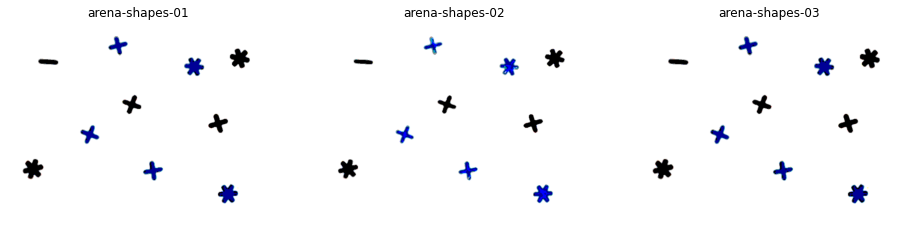

Executing function: region_growing

Found 10 regions in 9.0 seconds.
Found 10 regions in 9.0 seconds.
Found 10 regions in 10.0 seconds.


In [47]:
from skimage.filters import median

def pipeline(imgs, functions, visual = False):
    '''
    Help function to easily test different combinations of functions.
    
    '''
    for f in functions:
        print('Executing function: {}\n'.format(f.__name__))
        imgs = [f(imgs[i]) for i in range(NUM_IMAGES)]
        if visual and f.__name__ != 'region_growing':
            try:
                plot_imgs(imgs)
            except: 
                pass
        
    return imgs

imgs_regions = pipeline(images, [median, equalize_intensity, thresholding, region_growing], visual = True)

**Thoughts:**

10 Regions found by our pipeline, which is the expected amount.

### Label Regions

In [48]:
def calculate_regions_mean(img, regions):
    '''
    Returns the mean of each region in one image.
    
    '''
    np_regions = []
    for region in regions:
        np_region = []
        for x, y in region:
            np_region.append(img[x, y])
        np_regions.append(np.asarray(np_region).mean())
    
    return np.asarray(np_regions)
            

def label_regions(means):
    '''
    Return array with color of each region.
    '''
    threshold = means.mean() # Calculate average value of means
    labels = []
    for region, mean in enumerate(means):
        if mean >= threshold:
            labels.append('blue')
        else: 
            labels.append('black')
    
    return np.asarray(labels)
    
    
regions_mean = calculate_regions_mean(imgs_thres[0], imgs_regions[0])
labels = label_regions(regions_mean)


In [51]:
def plot_regions(regions, labels):
    '''
    Used to plot the regions to check results.
    
    '''
    f = plt.figure(figsize = (6,5))
    for nr, region in enumerate(regions):
        for x, y in region:
            plt.scatter(y, x, s = 0.01, color = labels[nr] )

        plt.text(y + 25, x + 25, nr, fontsize = 15, color = 'red')
    
    x_min, x_max, y_min, y_max = 0, 640, 0, 460
    plt.axis([x_min, x_max, y_max, y_min]) # Revert y_axis

    plt.title('Regions plotted with color')
    plt.show()
        
plot_regions(imgs_regions[0], labels)

### Results

In [ ]:
true_labels = np.asarray(['blue', 'black', 'blue', 'black', 'black', 'black', 'blue',
       'black', 'blue', 'blue'])
print('Accuracy of segmentation: {}%'.format(np.mean(labels == true_labels)*100))
colors, count = np.unique(labels, return_counts = True) 
for i in range(len(colors)):
    print('Found {} objects in the color {}'.format(count[i], colors[i]))

### 2.3 Total area (in pixels) of each color
Add your implementation and discussion

In [ ]:
def calculate_color_area(img_regions, labels):
    '''
    Calculates the area of each region based on found regions and labelling.
    
    '''
    area_blue = 0
    area_black = 0
    for i, region in enumerate(img_regions):
        if labels[i] == 'blue':
            area_blue += len(region)
        else:
            area_black += len(region)
            
    return area_blue, area_black
    
    
    
area_blue, area_black = calculate_color_area(imgs_regions[0], labels)

print('Number of blue pixels: {}. Number of black pixels: {}.'.format(area_blue, area_black))

**Thoughts:**

The only difference between the blue and black objects group is that blue has a plus and black has a minus. As the plus object consist of more pixels the expectation was that the black region would be smaller than the blue. This is confirmed by our above calculation.  